Import Statements

In [37]:
# -*- coding: utf-8 -*-

"""AuthentiEar_project_version.ipynb

Automatically generated by Colab.
Original file is located at
    https://colab.research.google.com/drive/1dCzzOA920wVR4gf77HzG7dNlgDAwvCOD

# In use Code

**This is a template code for a simple siamese network, made with tensorlow. Needs some work before it can be trained.**
"""

from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot, Layer, concatenate
from keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
#import keras.backend as K
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import os, sys
import glob
import tensorflow as tf
from tensorflow.keras.utils import plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,butter, sosfiltfilt, sosfreqz
from sklearn.preprocessing import RobustScaler
from scipy import signal
from PIL import Image

import librosa
from tqdm import tqdm
import random

#to-do before training


In [38]:

'''
1. Pre-processing code to get cleaned data
  a. re-sampling
  b. filtering
  c. outlier removal
  d. median filter
2. Windowing code -------------------------------- DONE
3. Image generation (12 channel)
4. Pairing code ---------------------------------- DONE
'''

#### Import data

#!unzip "authentiear_data.zip"

##### Pre-processing

## Resampling
## Bandpass filtering
## Outliers

"""**Windowing Code**"""

def window_data(data, fs, s, ov):
    """
    Windows a 1d np array of timeseries data into s second frames with ov percentage of overlap.
    Needs to be applied along every column

    Args:
        data: 1d np array of timeseries data.
        fs: Sampling rate in Hz.
        s: Window length in seconds.
        ov: Overlap rate as decimal point.

    Returns:
        2d np array of windowed data.
    """

    # Calculate the window length in samples.
    window_length = int(fs * s)

    # Calculate the overlap length in samples.
    overlap_length = int(window_length * ov)

    # Calculate the number of windows
    num_windows = int(np.ceil((len(data) - window_length) / (window_length - overlap_length))) + 1

    # Initialize the output array.
    windowed_data = np.zeros((num_windows, window_length))

    # Loop over the data and window it.
    for i in range(num_windows):
        start_index = i * (window_length - overlap_length)
        end_index = min(start_index + window_length, len(data))
        windowed_data[i, :end_index - start_index] = data[start_index:end_index]

    return windowed_data

# window_data(np.array([1,2,3,4,5,6,7,8,9,10]),2,2,0.5)


In [39]:

"""**Pre-processing**


"""

def pre_process(file_dir,person,order,lowcut,highcut,fs,s,ov):

  '''
  Args:
    file_dir: directory of all unzipped files
    person: person identifier. e.g. "P05"
    order: bpass filter order
    lowcut: low freq threshold for bpass
    highcut: high freq threshold for bpass
    fs: sampling frequency
    s: windowing time in second
    ov: overlap rate in decimal point
  Returns:
    windows of preprocessed data. (12 2D np arrays in a list, each 2D array has 1D windows from one column in the csv)
  '''

  # scan and list all files
  all_files = glob.glob(file_dir+"/**/*.csv",recursive=True)
  target_files = [x for x in all_files if person in x]
  print(target_files)
  data_l = [x for x in target_files if "ACC1" in x]
  data_r = [x for x in target_files if "ACC2" in x]

  # read left and right data
# read left and right data
  L=[]
  R=[]
  s_rate = str(int(1000/fs))+"ms"

  for idx in range(len(data_l)):
      L_=pd.read_csv(data_l[idx],names = ["timestamp","Ax","Ay","Az","Gx","Gy","Gz"])
      R_=pd.read_csv(data_r[idx],names = ["timestamp","Ax","Ay","Az","Gx","Gy","Gz"])

      # assign timestamp as index
      L_['timestamp'] = pd.to_datetime(L_['timestamp'], unit='ms')
      R_['timestamp'] = pd.to_datetime(R_['timestamp'], unit='ms')
      L_ = L_.set_index('timestamp')
      R_ = R_.set_index('timestamp')

      # resample files from both sensors to match up the values
      #https://stackoverflow.com/questions/17001389/pandas-resample-documentation
      L_=L_.resample(s_rate).mean()
      R_=R_.resample(s_rate).mean()

      # interpolate
      L_ = L_.interpolate(method="linear",axis=0)
      R_ = R_.interpolate(method="linear",axis=0)

      L.append(L_)
      R.append(R_)

  L = pd.concat(L)
  R = pd.concat(R)

  #pre-process (bandpass filter, windowing)
  data = []

  sos = butter(N=order, Wn=[lowcut,highcut], btype='bandpass', fs=fs, output='sos', analog=False)
  transformer = RobustScaler()

  for col in L.columns:
      signal = sosfiltfilt(sos, L[col])
      # signal = transformer.fit_transform(signal)
      data.append(window_data(np.array(signal),fs,s,ov))
  for col in R.columns:
      signal = sosfiltfilt(sos, R[col])
      # signal = transformer.fit_transform(signal)
      data.append(window_data(np.array(signal),fs,s,ov))

  return data



In [40]:

"""**Image generation**"""

def generate_image_2(data, fs=500, window_size=0.1, overlap=0.5, target_size=(64, 64)):

  num_channels = 12
  num_windows = data[0].shape[0]
  all_images = []

  nperseg = int(window_size * fs)
  noverlap = int(nperseg * overlap)

  for i in tqdm(range(data[0].shape[0])):
  # for i in tqdm(range(5)):
    combined_image = []
    for j in range(12):
      # p5_data[j][i]
      f, t, Sxx = signal.spectrogram(data[j][i], 500, window='hamming', nperseg=nperseg, noverlap=overlap)
      Sxx_dB = 10 * np.log10(Sxx)
      # Normalize the dB values to 0-255 for grayscale image
      Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
      # Convert to uint8
      Sxx_img = Sxx_norm.astype(np.uint8)
      # Resize image to target size
      img = Image.fromarray(Sxx_img)
      img_resized = img.resize(target_size)
      # Add to combined image
      combined_image.append(np.array(img_resized))
      # print(len(combined_image))
    # Stack images along the last axis to create a 12-channel image
    combined_image = np.stack(combined_image, axis=2)
    # print(combined_image.shape)
    # save images to master list
    all_images.append(combined_image)

  return all_images

# p_1_images = generate_image_2(p1_data)
# p_2_images = generate_image_2(p2_data)


In [41]:

"""**Pair Generation**"""

def get_pairs(lists, pos, neg):
  X1 = []
  X2 = []
  y = []

  for idx in range(pos+neg):
   #for positive, take from same list
    list_a = lists[random.randint(0,len(lists)-1)]

    X1.append(list_a[random.randint(0,len(list_a)-1)])
    X2.append(list_a[random.randint(0,len(list_a)-1)])
    y.append(0)

   #for negative, take from different lists
    ind_1 = random.randint(0,len(lists)-1)
    ind_2 = random.randint(0,len(lists)-1)
    while ind_1 == ind_2:
      ind_2 = random.randint(0,len(lists)-1)

    list_a = lists[ind_1]
    list_b = lists[ind_2]

    X1.append(list_a[random.randint(0,len(list_a)-1)])
    X2.append(list_b[random.randint(0,len(list_b)-1)])
    y.append(1)

  return X1,X2, y
  
"""**Triplet Generation**"""
def get_triplets(lists, num_triplets):
    X_anchor = []
    X_positive = []
    X_negative = []

    for _ in range(num_triplets):
        idx_a = random.randint(0, len(lists)-1)
        idx_b = random.randint(0, len(lists)-1)
        
        while idx_b == idx_a:
            idx_b = random.randint(0, len(lists)-1)
        
        list_a = lists[idx_a]
        list_b = lists[idx_b]
        
        anchor = list_a[random.randint(0, len(list_a)-1)]
        positive = list_a[random.randint(0, len(list_a)-1)]
        
        negative = list_b[random.randint(0, len(list_b)-1)]
        
        X_anchor.append(anchor)
        X_positive.append(positive)
        X_negative.append(negative)

    return X_anchor, X_positive, X_negative
    


In [42]:

"""# Wrapper code for functions"""
file_dir = ''
file_directory = "authentiear_data"
persons = ["P01","P02","P03","P05"]

#pre-process parameters
order = 2
lowcut = 10
highcut = 200
fs = 500
s = 15
ov = 0.2

prprcs_data = []
for prsn in persons:
  prprcs_data.append(pre_process(file_dir + file_directory,prsn,order,lowcut,highcut,fs,s,ov))

images = []
for x in prprcs_data:
  images.append(generate_image_2(x))


print(len(images), len(images[0]), len(images[1]), len(images[2]))

'''
X1,X2,y = get_pairs(images,pos,neg)

#save the models

model.save(os.getcwd()+"/base_model.h5")
siamese_model.save(os.getcwd()+"/full_network.h5")
'''



['authentiear_data/P01/P01-3ACC2.csv', 'authentiear_data/P01/P01-1ACC2.csv', 'authentiear_data/P01/P01-3ACC1.csv', 'authentiear_data/P01/P01-2ACC1.csv', 'authentiear_data/P01/P01-4ACC2.csv', 'authentiear_data/P01/P01-2ACC2.csv', 'authentiear_data/P01/P01-5ACC1.csv', 'authentiear_data/P01/P01-1ACC1.csv', 'authentiear_data/P01/P01-4ACC1.csv', 'authentiear_data/P01/P01-7ACC2.csv', 'authentiear_data/P01/P01-7ACC1.csv', 'authentiear_data/P01/P01-5ACC2.csv']
['authentiear_data/P02/P02-3ACC2.csv', 'authentiear_data/P02/P02-4ACC1.csv', 'authentiear_data/P02/P02-6ACC2.csv', 'authentiear_data/P02/P02-7ACC1.csv', 'authentiear_data/P02/P02-5ACC2.csv', 'authentiear_data/P02/P02-2ACC2.csv', 'authentiear_data/P02/P02-1ACC1.csv', 'authentiear_data/P02/P02-5ACC1.csv', 'authentiear_data/P02/P02-2ACC1.csv', 'authentiear_data/P02/P02-6ACC1.csv', 'authentiear_data/P02/P02-3ACC1.csv', 'authentiear_data/P02/P02-4ACC2.csv', 'authentiear_data/P02/P02-7ACC2.csv', 'authentiear_data/P02/P02-1ACC2.csv']
['authenti

 85%|████████▌ | 179/210 [00:00<00:00, 343.05it/s]/tmp/ipykernel_116500/1203239231.py:18: RuntimeWarning: divide by zero encountered in log10
  Sxx_dB = 10 * np.log10(Sxx)
/tmp/ipykernel_116500/1203239231.py:20: RuntimeWarning: invalid value encountered in subtract
  Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
/tmp/ipykernel_116500/1203239231.py:20: RuntimeWarning: invalid value encountered in divide
  Sxx_norm = (Sxx_dB - np.min(Sxx_dB)) / (np.max(Sxx_dB) - np.min(Sxx_dB)) * 255
/tmp/ipykernel_116500/1203239231.py:22: RuntimeWarning: invalid value encountered in cast
  Sxx_img = Sxx_norm.astype(np.uint8)
100%|██████████| 245/245 [00:00<00:00, 371.69it/s]

4 210 245 245


'\nX1,X2,y = get_pairs(images,pos,neg)\n\n#save the models\n\nmodel.save(os.getcwd()+"/base_model.h5")\nsiamese_model.save(os.getcwd()+"/full_network.h5")\n'

In [43]:

""" Triplet Loss Model"""


def triplet_loss(y_true, y_pred, alpha=0.175):
    """
    Triplet loss function.

    Parameters:
        y_true: true labels, not used in the loss function but required for Keras.
        y_pred: predicted output from the model.
        alpha: margin, a hyperparameter to control the relative importance of the positive and negative terms.

    Returns:
        Triplet loss value.
    """
    anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]

    # Triplet loss calculation
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)
    return K.mean(K.maximum(positive_distance - negative_distance + alpha, 0.0))

def triplet_loss_r(y_true, y_pred, alpha=0.175, beta = 0.2):
    """
    Triplet loss function with regularization.

    Parameters:
        y_true: true labels, not used in the loss function but required for Keras.
        y_pred: predicted output from the model.
        alpha: margin, a hyperparameter to control the relative importance of the positive and negative terms.
        beta: hyperparameter used to penalize large distances for positive examples.

    Returns:
        Triplet loss value.
    """
    anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]

    # Triplet loss calculation
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)
    triplet_loss = K.mean(K.maximum(positive_distance - negative_distance + alpha, 0.0))

    # Regularization term to penalize large distances for positive examples
    positive_regularization = K.mean(K.maximum(K.square(positive_distance) - beta, 0.0))

    return triplet_loss + positive_regularization


    
def triplet_accuracy(y_true, y_pred, alpha=0.175):
    """
    Triplet accuracy function.

    Parameters:
        y_true: true labels, not used in the accuracy function but required for Keras.
        y_pred: predicted output from the model.
        alpha: margin, a hyperparameter to control the relative importance of the positive and negative terms.

    Returns:
        Triplet accuracy value.
    """
    anchor, positive, negative = y_pred[:, :16], y_pred[:, 16:32], y_pred[:, 32:]

    # Triplet accuracy calculation
    positive_distance = K.sum(K.square(anchor - positive), axis=1)
    negative_distance = K.sum(K.square(anchor - negative), axis=1)
    print(positive_distance,negative_distance)
    return K.mean(K.maximum(positive_distance - negative_distance + alpha, 0.0) == 0.0)



In [44]:

'''Base Model'''
class NormalizationLayer(Layer):
    def __init__(self, **kwargs):
        super(NormalizationLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

input_layer = Input((64, 64, 12))
layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
layer3 = Conv2D(32, (3, 3), activation='relu', padding='same')(layer2)
layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
layer5 = Flatten()(layer4)
embeddings = Dense(16, activation=None)(layer5)
norm_embeddings = NormalizationLayer()(embeddings)

model = Model(inputs=input_layer, outputs=norm_embeddings)
print(model.summary())

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │       131,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_layer_1           │ (None, 16)             │             0 │
│ (NormalizationLayer)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,528 (611.44 KB)

 Trainable params: 156,528 (611.44 KB)

 Non-trainable params: 0 (0.00 B)

None


In [45]:

# Model definition
input_anchor = Input((64, 64, 12))
input_positive = Input((64, 64, 12))
input_negative = Input((64, 64, 12))

embedding_anchor = model(input_anchor)
embedding_positive = model(input_positive)
embedding_negative = model(input_negative)

triplet_loss_output = concatenate([embedding_anchor, embedding_positive, embedding_negative], axis=1)

# Triplet loss model
siamese_triplet_model = Model(inputs=[input_anchor, input_positive, input_negative], outputs=triplet_loss_output)

base_learning_rate = 0.01
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
siamese_triplet_model.compile(loss=triplet_loss_r, optimizer=optimizer, metrics = [triplet_accuracy])

print(siamese_triplet_model.summary())



Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_7        │ (None, 16)        │    156,528 │ input_layer_8[0]… │
│ (Functional)        │                   │            │ input_layer_9[0]… │
│                     │                   │            │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 48)        │          0 │ functional_7[0][… │
│ (Concatenate)       │                   │            │ functional_7[1][… │
│                     │                   │            │ functional_7[2][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 156,528 (611.44 KB)

 Trainable params: 156,528 (611.44 KB)

 Non-trainable params: 0 (0.00 B)

None


In [46]:

'''Train the Model'''


num_triplets = 8000

# Generate triplets
X_anchor, X_positive, X_negative = get_triplets(images, num_triplets)

# Convert lists to numpy arrays
X_anchor = np.array(X_anchor)
X_positive = np.array(X_positive)
X_negative = np.array(X_negative)

# Create dummy labels (triplet loss does not use labels during training)
y_dummy = np.zeros((num_triplets, 3))

# Fit the model
history = siamese_triplet_model.fit([X_anchor, X_positive, X_negative], y_dummy,
                                    validation_split = 0.2, epochs=250, batch_size=200, shuffle=True, verbose=True)


Epoch 1/250
Tensor("Sum_2:0", shape=(200,), dtype=float32) Tensor("Sum_3:0", shape=(200,), dtype=float32)
Tensor("Sum_2:0", shape=(200,), dtype=float32) Tensor("Sum_3:0", shape=(200,), dtype=float32)
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1769 - triplet_accuracy: 4.0762e-04Tensor("Sum_2:0", shape=(200,), dtype=float32) Tensor("Sum_3:0", shape=(200,), dtype=float32)
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.1768 - triplet_accuracy: 3.9239e-04 - val_loss: 0.1750 - val_triplet_accuracy: 0.0000e+00
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1750 - triplet_accuracy: 0.0000e+00 - val_loss: 0.1750 - val_triplet_accuracy: 0.0000e+00
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1750 - triplet_accuracy: 0.0000e+00 - val_loss: 0.1750 - val_triplet_accuracy: 0.0000e+00
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1750 - triplet_accuracy: 0.0000e+00 - val_loss: 0.1750 - val_triplet_accuracy: 0.0000e+00
Epoch 5/250
32/32 ━━━━━━━

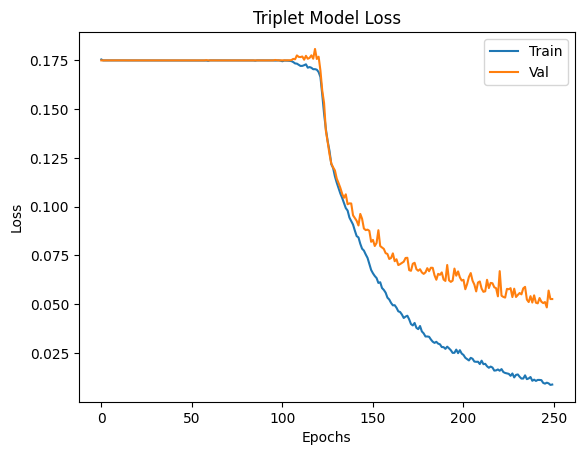

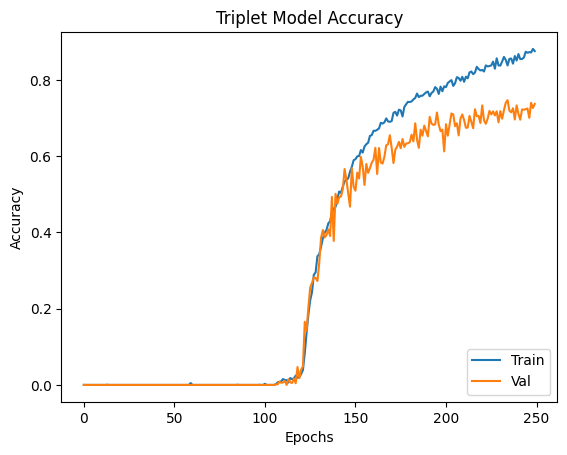

In [47]:

# Plotting loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Triplet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Plotting accuracy
plt.figure(2)
plt.plot(history.history['triplet_accuracy'])
plt.plot(history.history['val_triplet_accuracy'])
plt.title('Triplet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

#plot_model(model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)

#plot_model(siamese_model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)


In [48]:
'''Test Model'''
num_triplets = 1000
y_dummy = np.zeros((num_triplets, 3))
X_anchor, X_positive, X_negative = get_triplets(images, num_triplets)
# Evaluate the model
scores = siamese_triplet_model.predict([np.array(X_anchor), np.array(X_positive), np.array(X_negative)])
#print(scores)
#print(scores.shape)

anchor, positive, negative = scores[:, :16], scores[:, 16:32], scores[:, 32:]
positive_distance = K.sum(K.square(anchor - positive), axis=1)
negative_distance = K.sum(K.square(anchor - negative), axis=1)
preds = positive_distance < negative_distance

siamese_triplet_model.evaluate([np.array(X_anchor), np.array(X_positive), np.array(X_negative)], y_dummy,batch_size = 50, verbose=True)



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Tensor("Sum_2:0", shape=(None,), dtype=float32) Tensor("Sum_3:0", shape=(None,), dtype=float32)
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0583 - triplet_accuracy: 0.7131


[0.05507360398769379, 0.7369999885559082]

In [49]:

# Function to compute Euclidean distance between two vectors
def euclidean_distance(vects):
    x, y = vects
    sum_square = np.sum(np.square(x - y), axis=1, keepdims=True)
    return np.sqrt(sum_square)

# Function to predict authentication
def predict_authentication(model, anchor_image, test_image, threshold):
    # Embedding for anchor image
    anchor_embedding = model.predict(anchor_image[np.newaxis, ...],verbose=0)
    
    # Embedding for test image
    test_embedding = model.predict(test_image[np.newaxis, ...], verbose=0)
    
    # Compute distance between embeddings
    distance = euclidean_distance([anchor_embedding, test_embedding])
    # Compare distance with threshold
    if distance < threshold:
        return 0  # Authentic
    else:
        return 1  # Not Authentic

def get_predictions(model, anchor_image, test_image):
    # Embedding for anchor image
    anchor_embedding = model.predict(anchor_image[np.newaxis, ...],verbose=0)
    
    # Embedding for test image
    test_embedding = model.predict(test_image[np.newaxis, ...], verbose=0)
    
    # Compute distance between embeddings
    distance = euclidean_distance([anchor_embedding, test_embedding])
    return distance[0][0]
    
def get_far_frr(y_true, y_pred):
  '''
  y_true: actual labels of data (0 if user should be granted access,
                                1 if user should be denied access) 
  y_pred: predicted labels of data

  returns: False Acceptance Rate and False Rejection Rate based on given
  actual and predicted labels of the data
  '''
  tp = 0
  fp = 0
  tn = 0
  fn = 0
  for i in range(len(y_true)):
    if y_true[i] == y_pred[i] == 0:
      tp += 1
    elif y_true[i] == y_pred[i] == 1:
      tn += 1
    elif y_pred[i] == 0:
      fp += 1
    elif y_pred[i] == 1:
      fn += 1
  return fp/(fp+tn), fn/(fn+tp)
  


In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [51]:
pos = 500
neg = 500
X1,X2,y = get_pairs(images,pos,neg)
t_values = [x/1000 for x in range(200,950)]
#print([predict_authentication(model,X1[i],X2[i], 0.5) for i in range(len(y))])
distances = [get_predictions(model, X1[i], X2[i]) for i in range(len(y))]
print(distances)
eer = 0
far_plot = []
frr_plot =[]
acc_plot = []
f1_plot = []
precision_plot = []
recall_plot = []
for t in t_values:
    #print('threshold: ', t, np.mean([predict_authentication(model,X1[i],X2[i], t) == y[i] for i in range(len(y))]))
    predicted_labels = [distances[i] > t for i in range(len(distances))]
    far, frr = get_far_frr(y, predicted_labels)
    acc = np.mean([(distances[i] > t) == y[i] for i in range(len(y))])
    far_plot.append(far)
    frr_plot.append(frr)
    acc_plot.append(acc)
    accuracy = accuracy_score(y, predicted_labels)
    precision = precision_score(y, predicted_labels)
    recall = recall_score(y, predicted_labels)
    f1 = f1_score(y, predicted_labels)
    f1_plot.append(f1)
    precision_plot.append(precision)
    recall_plot.append(recall)
    print('threshold: ', t, 'accuracy: ', acc, 'far, frr: ', (far, frr), precision, recall, f1 )
    if np.abs(far - frr) < 0.01:
        print('EQUAL ERROR RATE: ', far, frr)

[0.6433401, 0.61925036, 0.58307564, 1.0133486, 0.45603496, 1.4428474, 0.3246557, 0.78711027, 0.70461816, 1.2033224, 0.60775626, 0.71722686, 0.352636, 1.266967, 0.41882133, 0.8357676, 0.687648, 0.68075997, 0.46362126, 0.41831937, 0.60511255, 0.75819975, 0.64487934, 0.7235288, 0.42226216, 0.9226406, 0.65351033, 1.1750323, 0.41699243, 0.9268868, 0.3306322, 0.6139278, 0.47634563, 0.4703896, 0.5248237, 0.8114525, 0.6009615, 0.6391124, 0.46744928, 0.5983927, 0.35426566, 1.3633969, 0.5121173, 1.5198592, 0.5683908, 1.050903, 0.53799134, 0.9196813, 0.4966232, 1.0573307, 0.44424084, 1.1217812, 0.5075116, 0.88323665, 0.5843644, 0.42023036, 0.54814184, 0.67392534, 0.6853476, 0.7333448, 0.53821796, 1.4505651, 0.67435557, 1.2424638, 0.50698143, 1.4167793, 0.62718916, 1.0688148, 0.47590414, 1.2508019, 0.3385548, 1.0421457, 0.47640684, 0.8468446, 0.34652027, 1.0758103, 0.39579257, 0.69300824, 0.63715935, 0.61198, 0.54699767, 1.2932154, 0.41805905, 1.2564361, 0.46356586, 0.6596269, 0.5305633, 0.7143377

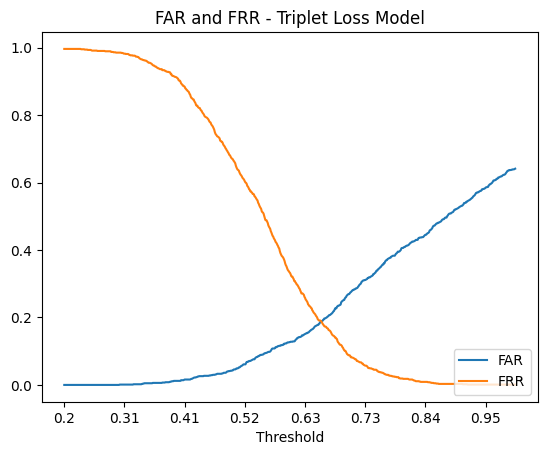

In [52]:
t = np.linspace(min(t_values), max(t_values), num=int(len(frr_plot)/100 + 1))
plt.plot( far_plot)
plt.plot( frr_plot)
plt.title('FAR and FRR - Triplet Loss Model')
plt.xlabel('Threshold')
plt.xticks(np.arange(0, len(frr_plot), step=100), labels= t.round(2))
plt.ylabel('')
plt.legend(['FAR', 'FRR'], loc='lower right')
plt.show()

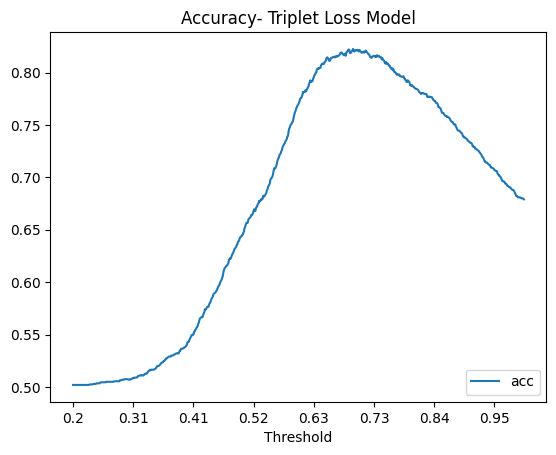

In [53]:
t = np.linspace(min(t_values), max(t_values), num=int(len(frr_plot)/100 + 1))
plt.plot( acc_plot)
plt.title('Accuracy- Triplet Loss Model')
plt.xlabel('Threshold')
plt.xticks(np.arange(0, len(frr_plot), step=100), labels= t.round(2))
plt.ylabel('')
plt.legend(['acc'], loc='lower right')
plt.show()

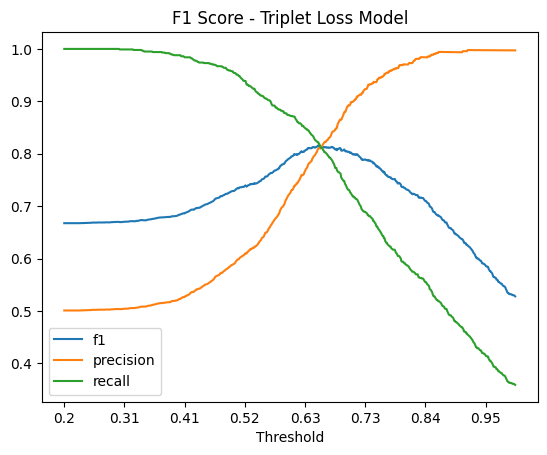

In [54]:
t = np.linspace(min(t_values), max(t_values), num=int(len(frr_plot)/100 + 1))
plt.plot( f1_plot)
plt.plot(precision_plot)
plt.plot(recall_plot)
plt.title('F1 Score - Triplet Loss Model')
plt.xlabel('Threshold')
plt.xticks(np.arange(0, len(frr_plot), step=100), labels= t.round(2))
plt.ylabel('')
plt.legend(['f1', 'precision', 'recall'], loc='lower left')
plt.show()

In [55]:

threshold = 0.6
predicted_labels = [distances[i] > threshold for i in range(len(distances))]
accuracy = accuracy_score(y, predicted_labels)
precision = precision_score(y, predicted_labels)
recall = recall_score(y, predicted_labels)
f1 = f1_score(y, predicted_labels)
print(accuracy, precision, recall, f1)

0.7955 0.7669376693766937 0.849 0.8058851447555766
